In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timezone, timedelta
from adtk.detector import QuantileAD
from adtk.visualization import plot 

In [2]:
pd.options.mode.chained_assignment = None  # default='warn'

# Loading the dataset

In [3]:
chunks = []
for chunk in pd.read_csv("live_experience.csv.csv", chunksize=100000):
    chunks.append(chunk)

df = pd.concat(chunks)

In [4]:
df.drop_duplicates(inplace=True)

In [5]:
print("rows of dataset:", len(df.index))

rows of dataset: 8347801


# Answers to questions

## 1. Filtering by Date (Taiwan Time)

In [6]:
# To define the timezone as UTC+8 (Taiwan's Timezone)
tz = timezone(timedelta(hours=+8))

In [7]:
# Adding a new column of event date to dataframe
df["event_datetime"] = df["event_timestamp"].apply(lambda x: datetime.fromtimestamp(x / 1000000).astimezone(tz))

In [8]:
# Filtering
filter_start = datetime(2019, 8, 31, 0, 0, 0).astimezone(tz)
filter_end = datetime(2019, 9, 29, 23, 59, 59).astimezone(tz)

filtered_df = df[(df["event_datetime"] > filter_start) & (df["event_datetime"] < filter_end)] 

## 2-a. Countries

In [9]:
# For generating pie chart
def generate_pie_chart(df, title:str):
    df.plot(kind="pie", autopct = "%1.2f%%", pctdistance = 0.75, figsize=(6, 8), textprops = {"fontsize" : 12}, shadow=True, ylabel="")                                                 
    plt.title(title, {"fontsize" : 18})        
    plt.show()   

country
Canada             347518
United Kingdom     372597
United States     6091186
Name: country, dtype: int64


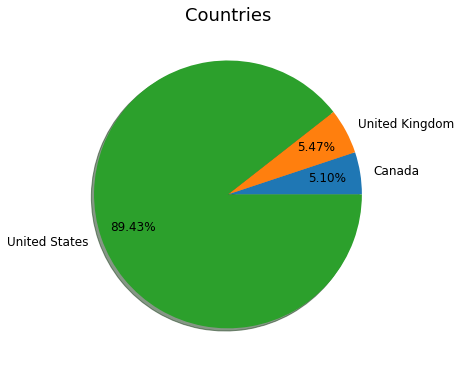

In [10]:
countries = filtered_df.groupby("country")["country"].count()
print(countries)

generate_pie_chart(df=countries, title="Countries")


## 2b. Platforms

platform
ANDROID    5034890
IOS        1776411
Name: platform, dtype: int64


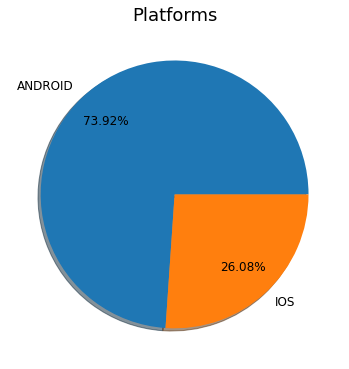

In [11]:
platforms = filtered_df.groupby("platform")["platform"].count()
print(platforms)

generate_pie_chart(df=platforms, title="Platforms")

## 2-c. Start date of datasest

In [12]:
filtered_df["event_date"] = filtered_df["event_datetime"].apply(lambda x: x.strftime("%Y-%m-%d"))

In [13]:
data_start_date = filtered_df["event_date"].min()
print("start date:", data_start_date)

start date: 2019-08-31


## 2-d. End date of dataset

In [14]:
data_end_date = filtered_df["event_date"].max()
print("end date:", data_end_date)

end date: 2019-09-29


## 2-e. Number of days in dataset

In [15]:
unique_dates = filtered_df["event_date"].unique()
unique_dates.sort()
print("number of days:", len(unique_dates))

number of days: 30


## 2-f. Total number of lives

In [16]:
total_number_of_lives = len(filtered_df.index)
print("Total number of lives:", total_number_of_lives)

Total number of lives: 6811301


## 2-g. Average number of lives per day

In [17]:
print("Avg. number of lives per day:", round(total_number_of_lives/len(unique_dates), 2))

Avg. number of lives per day: 227043.37


## 2-h. Success rate of live video connection in the period

In [18]:
successful_connections = filtered_df[(filtered_df["first_video_frame"] != -1) & (filtered_df["first_video_frame"] <= 10000)]
number_of_successful_connection = len(successful_connections)

# How to demonstrate the success rate of live video connection in the period
success_rate = (number_of_successful_connection / total_number_of_lives) * 100

# Check the rate
print(f"Success rate: {round(success_rate, 2)}%")

Success rate: 77.68%


## 3. Success rate of live video connection by date

In [19]:
"""For transforming the data as a time series dataframe with daily success rates"""

def get_success_rate_by_date(filtered_df):
    # defining connection status: 1 for success, 0 for failed (both failed connection and anomalous data record) 
    filtered_df["conn_status"] = filtered_df["first_video_frame"].apply(lambda x: 0 if x == -1 or x > 10000 else 1)
    
    unique_dates = filtered_df["event_date"].unique()
    unique_dates.sort()
    
    # To get counts of every video connections status for each day
    conn_status_counts_by_date = filtered_df[["uid", "conn_status", "event_date"]].groupby(["event_date", "conn_status"]).count()
    # To get an array of success counts by date
    success_counts = conn_status_counts_by_date.query("conn_status == 1").groupby("event_date").sum()["uid"].values
    # To get an array of fail counts by date
    live_counts = conn_status_counts_by_date.groupby(["event_date"]).sum()["uid"].values
    
    # Create a new dataframe of success rate by date
    success_rates_by_date = pd.DataFrame(success_counts / live_counts, columns=["success_rate"], index=unique_dates)
    return success_rates_by_date

In [20]:
success_rates_by_date = get_success_rate_by_date(filtered_df)

In [21]:
""" For demonstrating the success rates by bar chart """

def generate_bar_chart(success_rates_by_date, title_affix="all countries/platforms"):
    ylim_range = (success_rates_by_date["success_rate"].min()-0.05, success_rates_by_date["success_rate"].max()+0.05)
    ax = success_rates_by_date.plot(kind="bar", figsize=(24, 6), rot=75, legend=False, ylim=ylim_range, yticks=[])
    plt.title("Success rate of video connection by date"+ f" ({title_affix})", fontsize=18)

    for p in ax.patches:
        ax.annotate(str(round(p.get_height(), 3)), (p.get_x(), p.get_height() * 1.002))

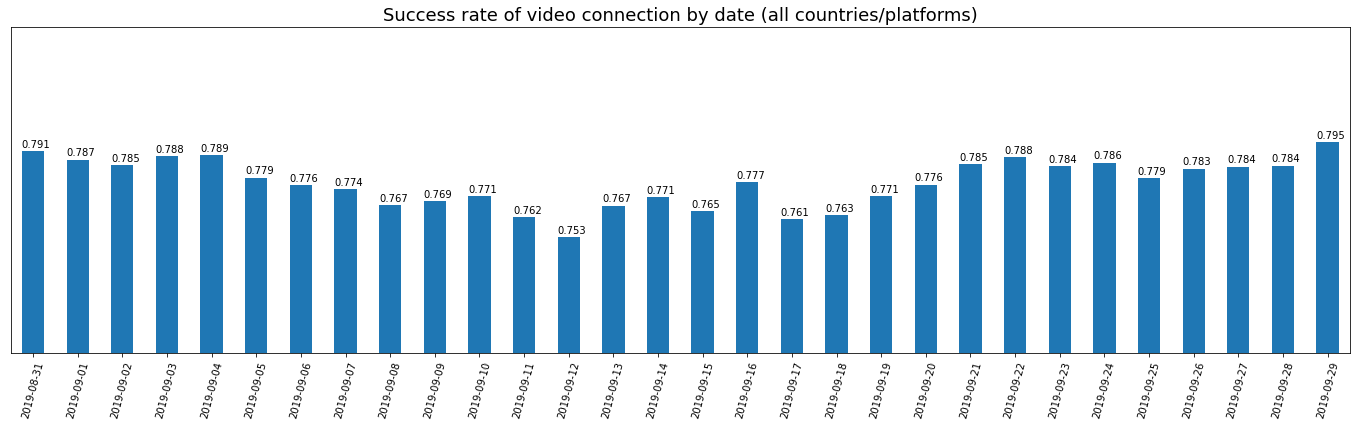

In [22]:
generate_bar_chart(success_rates_by_date)

## 4. Anomaly detection

In [23]:
"""For getting the detected anomalus dates from data"""

def anomaly_detection(success_rates_by_date, subset="all platforms/"):
    # Reset the index as timestamp format
    df = pd.DataFrame(success_rates_by_date.values, index=pd.DatetimeIndex(success_rates_by_date.index), columns=["success_rate"])

    # Applying Quantile Anormaly Detection from adtk (Anomaly Detection Toolkit) library
    quantile_ad = QuantileAD(low=0.05, high=1) # Defining anomaly as lower than 0.05 percentile
    anomalies = quantile_ad.fit_detect(df)
    
    # plotting
    chart = plot(df, 
            anomaly=anomalies, 
            ts_linewidth=2, 
            ts_markersize=4,
            anomaly_markersize=8,
            anomaly_tag='marker')
    
    plt.title(f"Anomaly chart {(subset)}")
    plt.xticks(success_rates_by_date.index, rotation=75)
    
    # return the dates which are detected as anomalous
    anomalous_dates = anomalies.query("success_rate == True")
    return anomalous_dates

            success_rate
2019-09-12          True
2019-09-17          True


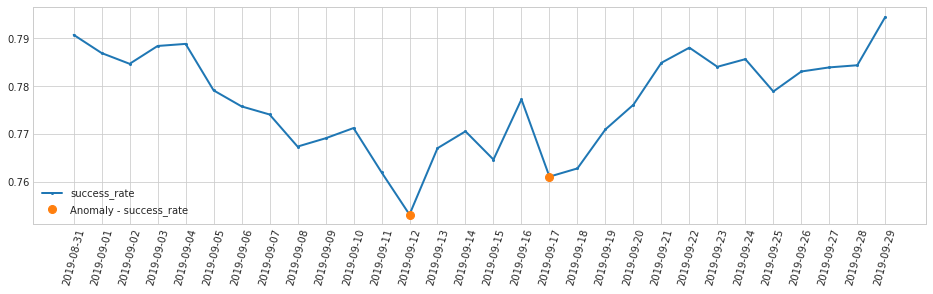

In [24]:
print(anomaly_detection(success_rates_by_date))

## 5. Comparison between data with countries / platforms

In [25]:
def compare_trend_and_anomaly(filtered_df, filter_by:str, col_name:str):
    anomalous_dates = anomaly_detection(get_success_rate_by_date(filtered_df[filtered_df[filter_by] == col_name]))["success_rate"]
    return anomalous_dates


<Canada>
2019-09-12    True
2019-09-13    True
Name: success_rate, dtype: bool


<United Kingdom>
2019-09-01    True
2019-09-08    True
Name: success_rate, dtype: bool


<United States>
2019-09-12    True
2019-09-18    True
Name: success_rate, dtype: bool



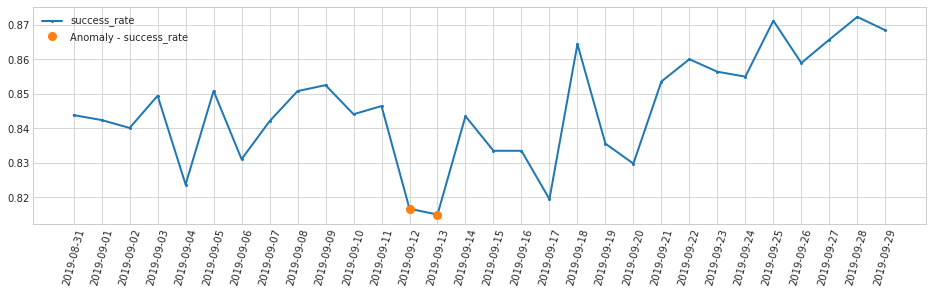

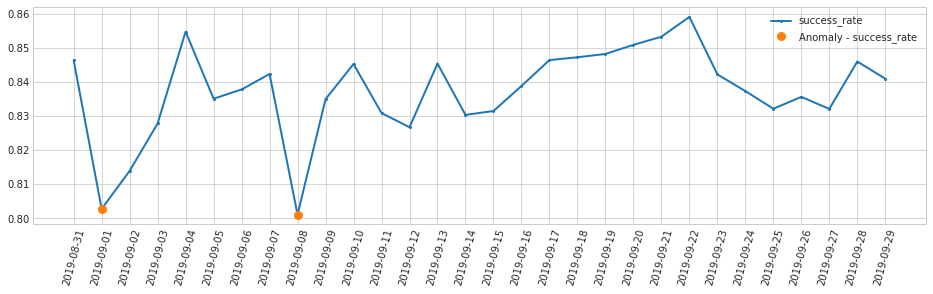

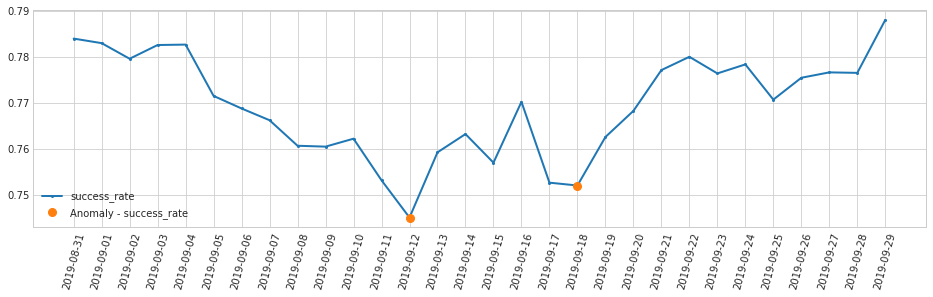

In [26]:
# Check different countries
countries_comparisons = {countries.index[i]:compare_trend_and_anomaly(filtered_df, "country", countries.index[i]) for i in range(len(countries.index))}

for key, value in countries_comparisons.items():
    print(f"\n<{key}>\n{value}\n")


<ANDROID>
2019-09-12    True
2019-09-17    True
Name: success_rate, dtype: bool


<IOS>
2019-09-11    True
2019-09-12    True
Name: success_rate, dtype: bool



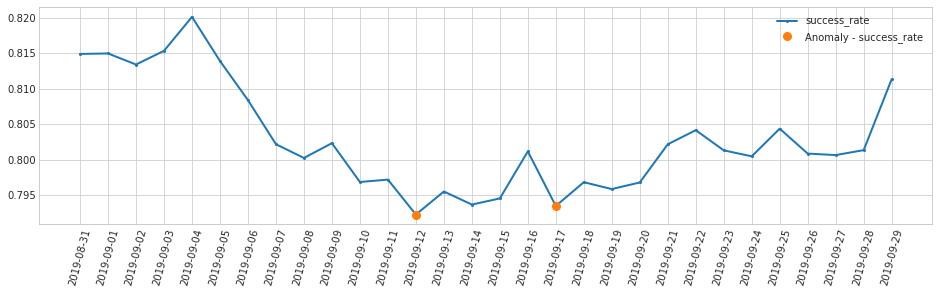

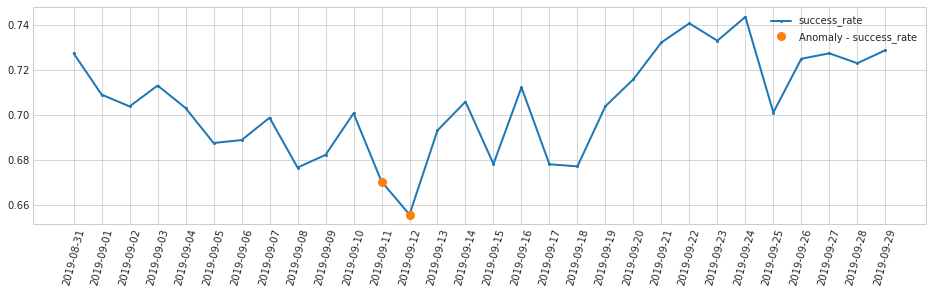

In [27]:
# Check different plaforms
platforms_comparisons = {platforms.index[i] : compare_trend_and_anomaly(filtered_df, "platform", platforms.index[i]) for i in range(len(platforms.index))}

for key, value in platforms_comparisons.items():
    print(f"\n<{key}>\n{value}\n")